### 1.3 Bayesian Inverse Approach for a UQ Problem

Uncertainty Quantification (UQ) is a field that concerns the identification, characterization and estimation of uncertainty in mathematical modeling. It provides an understanding of how uncertainties in input parameters affect the outputs of interest. In this section, we focus on the backward propagation of uncertainty in the solution of inverse problem, specifically by using a Bayesian probabilistic perspective. The goal of this approach is to analyze how to estimate model parameters from data. It combines prior information with likelihoods derived from the data to approximate posterior distribution.

#### 1.3.1 Key Concept 
We write inverse problem setting of the form 
\begin{equation}
y = G(u) + \eta
\end{equation}
where $G:\mathbb{R}^d \rightarrow \mathbb{R}^k$ is the (well-posed) forward model and $\eta \in \mathbb{R}^k$ represents noise with distribution $\nu$. 

Our goal is to determine an unknown parameter $u \in \mathbb{R}^d$ with prior distribution $\rho$ from the given data $y \in \mathbb{R}^k$. For each fixed $u \in \mathbb{R}^d$, $y|u \sim \nu(y-G(u))$ determines the likelihood function. By using Bayes' theorem, for an observed $y$, the posterior distribution $u|y$ which is the solution to the inverse problem takes the form 
\begin{equation}
\pi^{y}(u) = \frac{1}{Z}\nu(y-G(u))\rho(u)
\end{equation}


#### 1.3.2 Case Study
In this case study, the thermal conductivity $k$ is considered as uncertain parameter based on observed data $T$. If we assume that prior $\rho(k) = N(200, 20^2)$ and $\eta \sim N(0, 0.4)$, we can then construct the likelihood function and posterior distribution. 

Fix the mesh size as $\Delta x = \Delta y = 1$ $cm$ and numerically generate datum $T$ for $k_{true}=200$ by calling UM-Bridge model.

In [1]:
# umbridge client
import umbridge
import numpy as np

model = umbridge.HTTPModel("http://0.0.0.0:4242", "forward")
data = np.array(model([[200, 4 ]]))
print(data)

[[13835.71428571 17605.35714286 13835.71428571 17537.5
  22550.         17537.5        13764.28571429 17519.64285714
  13764.28571429]]


In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special
from mpl_toolkits.mplot3d import axes3d
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
import numpy
from scipy.linalg import block_diag
from scipy import linalg


# consider the inverse problem setting y = G(u) + ɲ where lets say ɲ ~ N(0, 0.4*I) 
# can we reconstruct this eqn. like this T = G(k) + ɲ 
# and in our case "k" thermal conductivity is uncertain parameter and lets say the distribution of the prior is g(k) = N(200, 20)
# which means that we assume Gaussian prior 
std_prior = 20
mu_prior = 200
std_noise = 0.4
mu_noise = 0

# defining log-prior distribution  
def g(k):
    log_prior_pdf = -0.5*np.log(2*np.pi*std_prior) - 0.5*(((k - mu_prior)**2)/(std_prior))
    return log_prior_pdf


# defining likelihood function at specific points (xi, yi): T_obs(xi, yi)|k ~ N( T(xi, yi; k), 0.4 ) with given k_true=200
# T(xi, yi; k) is the temperature predicted by solving the heat eqn. with given k
# since we have 9 observation points with their respective temperatures, for each observation point we need to calculate likelihood
# If we have multiple observation points, the joint likelihood is the product of individual likelihoods

# where data is obtained by solving the heat conduction problem by using the k_true=200
# flatten imples T_obs is one-dimentional. So we have 9 observed temperature data 
T_obs = (data + np.random.normal(mu_noise, std_noise, data.shape)).flatten()
d = len(T_obs)

def f(k):
    T_model_array= np.array(model([[k, 4 ]]))
    T_model = T_model_array.flatten()   #during MCMC candidate values for k will be proposed and for each k, the forward model will be solved 
    cov_matrix = std_noise*np.identity(d)
    inverse_cov_matrix = np.linalg.inv(cov_matrix)
    diff = T_obs - T_model
    log_likelihood_pdf = -0.5*d*np.log(2*np.pi) - 0.5*np.log(np.linalg.det(cov_matrix)) - 0.5* (diff.T @ (inverse_cov_matrix) @ diff)
    return log_likelihood_pdf

# constructing posterior 
def p(k):
    log_post_pdf = g(k) + f(k) 
    return log_post_pdf



#### 1.3.3 Markov Chain Monte Carlo (MCMC)

Since the direct sampling from the posterior distribution is not possible, we are utilizing Markov Chain Monte Carlo (MCMC) method. One of the popular algorithms for MCMC is Metropolis Hastings algorithm. In this case study, we generate Markov Chain with initial distribution 
$ N(k_{current \textunderscore state}, 1)$  where $k_0 = 200$.

[200.         200.         200.         ... 200.00158676 200.00158676
 200.00158676]


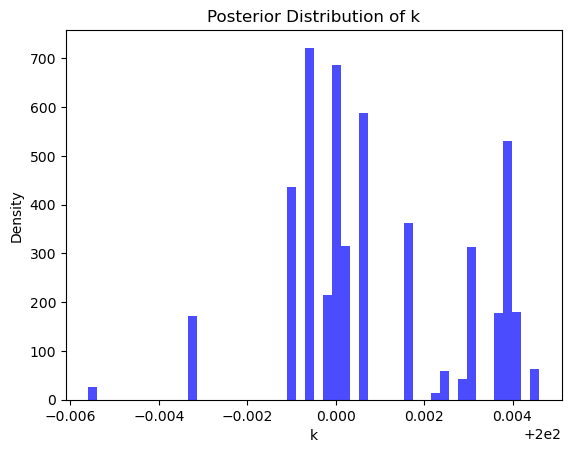

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
#import arviz as az

# Connect to the umbridge model
#model = umbridge.HTTPModel("http://0.0.0.0:4242", "forward")

# post_pdf = g(x) * f(T) # renamed k to x
# Define the 1-dimensional target (posterior) distribution
#def target_distribution(k): # needs to be changed to return g(x) * f(T)
#    return norm.pdf(k, loc=0, scale=1)  # Standard normal distribution # needs to be changed


# target_distribution(x) is actually our posterior p(k)


# Define the proposal distribution
def proposal_distribution(k):
    return np.random.normal(k, 1) # gaussian centered on the current state

# Metropolis-Hastings algorithm
def metropolis_hastings(initial_state, num_samples, p, proposal_distribution):
    samples = []  # List to store the samples
    k = initial_state  # Start from the initial state
    
    for j in range(num_samples):
        # Given the current state x_j = x, draw a realization x' from Q(x, .)
        k_prime = proposal_distribution(k)
    
        # Compute the acceptance probability α(x, x')
        alpha = min(1, np.exp( p(k_prime) - p(k)  ))
        
        # Draw an independent sample u_j+1 ~ uniform[0, 1]
        u = np.random.uniform(0, 1)
        
        # Set x_{j+1}
        if u <= alpha:
            k = k_prime  # Accept the new state
          
        samples.append(k) # Store the current state (whether accepted or not)
       
    return np.array(samples) 

# Parameters
initial_state = 200
num_samples = 5000

# Run Metropolis-Hastings algorithm
samples= metropolis_hastings(initial_state, num_samples, p, proposal_distribution)
print(samples)



# plotting

plt.hist(samples, bins=50, density=True, alpha=0.7, color='blue')
plt.title('Posterior Distribution of k')
plt.xlabel('k')
plt.ylabel('Density')
plt.show()

In [ ]:
pip install pymc3 arviz

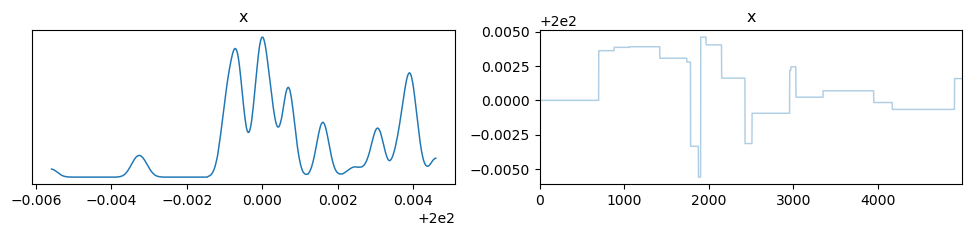

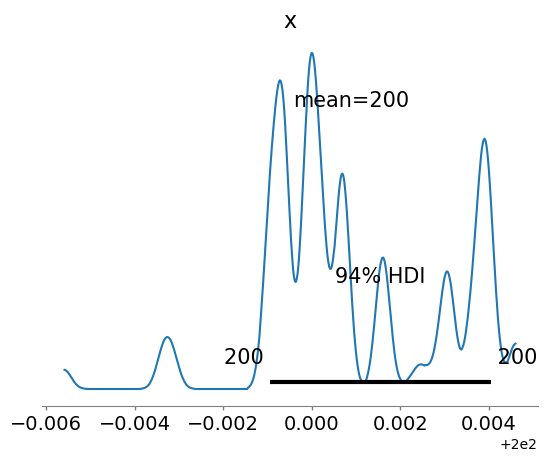

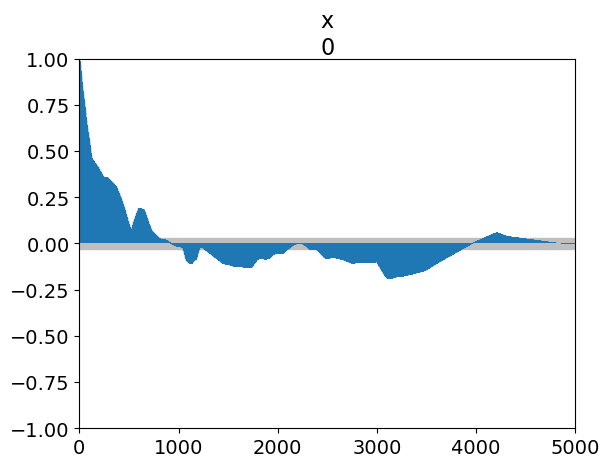

In [4]:
# Use ArviZ to create an InferenceData object
import arviz as az

az_data = az.from_dict(posterior={'x': samples})

# Plot the results using ArviZ
az.plot_trace(az_data)
plt.show()

# Plot the posterior density using ArviZ
az.plot_posterior(az_data)
plt.show()

# Plot the autocorrelation of the samples
az.plot_autocorr(az_data,max_lag=5000)
plt.show()